In [1]:
import simpy
import matplotlib.pyplot as plt

# Inputs 

# Capacities (gal)

tank_1_size = 100
tank_2_size = 100 
drum_size = 20

# Flowrates (gpm)

tank_1_fill_flowrate = 5
tank_1_empty_flowrate = 5
tank_2_fill_flowrate = 5
tank_2_empty_flowrate = 5

volume = []  # List to store volume in data
drum_throughput = [] # List to store filled drums

# Model 

def tank_operations(env):
    
    tank_1 = simpy.Container(env, capacity=tank_1_size)
    tank_2 = simpy.Container(env, capacity=tank_2_size)
    drums = [simpy.Container(env, capacity=drum_size)] 
    
    total_volume = 1000 # Total Volume to Process(gallons)
    total_volume_in = 0
    total_volume_processed = 0
    
    while total_volume_in < total_volume:
        
        # Initial fill of tank 1
           
        if tank_1.level == 0 and tank_2.level == 0:
            while (tank_1.level < tank_1_size) and (total_volume_in < total_volume):
                
                yield tank_1.put(tank_1_fill_flowrate)
                total_volume_in += tank_1_fill_flowrate
                
                volume.append((env.now, tank_1.level, tank_2.level, drums[-1].level))
                yield env.timeout(1) 
        
        else:

         # Alternating fill of tank 1 and tank 2
        
            while tank_2.level < tank_2_size and (total_volume_in < total_volume):
    
                    yield tank_2.put(tank_2_fill_flowrate)
                    total_volume_in += tank_2_fill_flowrate
            
                    if drums[-1].level < drum_size:
                        yield tank_1.get(tank_1_empty_flowrate)
                        yield drums[-1].put(tank_1_empty_flowrate)
                        total_volume_processed += tank_1_empty_flowrate
                        
                    if drums[-1].level == drum_size:
                        drums.append(simpy.Container(env, capacity=drum_size))
                        drum_throughput.append((env.now, 1))
                
                    volume.append((env.now, tank_1.level, tank_2.level, drums[-1].level))
                    yield env.timeout(1)  
                 
            while (tank_1.level < tank_1_size) and (total_volume_in < total_volume):

                    yield tank_1.put(tank_1_fill_flowrate)
                    total_volume_in += tank_1_fill_flowrate
                    
                    if drums[-1].level < drum_size:
                        yield tank_2.get(tank_2_empty_flowrate)
                        yield drums[-1].put(tank_2_empty_flowrate)
                        total_volume_processed += tank_2_empty_flowrate
                        
                    if drums[-1].level == drum_size:
                        drums.append(simpy.Container(env, capacity=drum_size))
                        drum_throughput.append((env.now, 1))
                
                    volume.append((env.now, tank_1.level, tank_2.level, drums[-1].level))
                    yield env.timeout(1)
                
    # Process remaining feed after total volume has been reached            
            
    if total_volume_in == total_volume:
        while tank_1.level > 0:
            if drums[-1].level < drum_size:
                
                yield tank_1.get(tank_1_empty_flowrate)
                yield drums[-1].put(tank_1_empty_flowrate)      
                total_volume_processed += tank_1_empty_flowrate
                
            if drums[-1].level == drum_size and tank_1.level > 0:
                drums.append(simpy.Container(env, capacity=drum_size))
                
            volume.append((env.now, tank_1.level, tank_2.level, drums[-1].level))
            yield env.timeout(1)
            
        while tank_2.level > 0:
            if drums[-1].level < drum_size:
                
                yield tank_2.get(tank_2_empty_flowrate)
                yield drums[-1].put(tank_2_empty_flowrate)   
                total_volume_processed += tank_2_empty_flowrate
                
            if drums[-1].level == drum_size and tank_2.level > 0:
                drums.append(simpy.Container(env, capacity=drum_size))
                
            volume.append((env.now, tank_1.level, tank_2.level, drums[-1].level))
            yield env.timeout(1)       
            
            
    print('Total Volume In:', total_volume_in)
    print('Total Volume Processed:', total_volume_processed)
    print('Number of drums filled:', len(drums))
    print('Simulation end time:', max(data[0] for data in volume), 'min')

In [2]:
env = simpy.Environment()
env.process(tank_operations(env))
env.run() 

Total Volume In: 1000
Total Volume Processed: 1000
Number of drums filled: 50
Simulation end time: 219 min


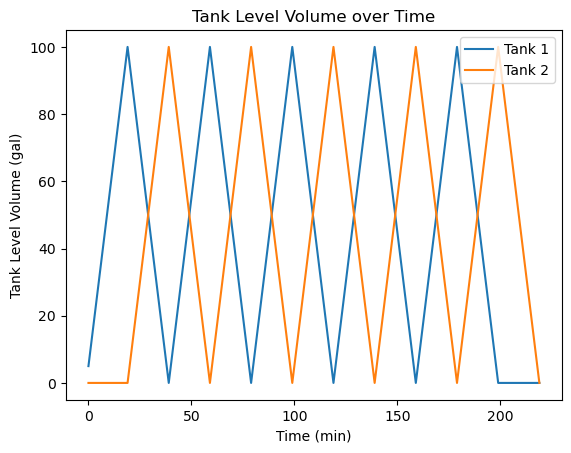

In [3]:
# Extract time and volume data from the list
time = []
tank_1_volume = []
tank_2_volume = []

for data in volume:
    time.append(data[0])
    tank_1_volume.append(data[1])
    tank_2_volume.append(data[2])

# Create the plot for tank level volumes
plt.plot(time, tank_1_volume, label='Tank 1')
plt.plot(time, tank_2_volume, label='Tank 2')
plt.xlabel('Time (min)')
plt.ylabel('Tank Level Volume (gal)')
plt.title('Tank Level Volume over Time')
plt.legend()

# Display the plot
plt.show()

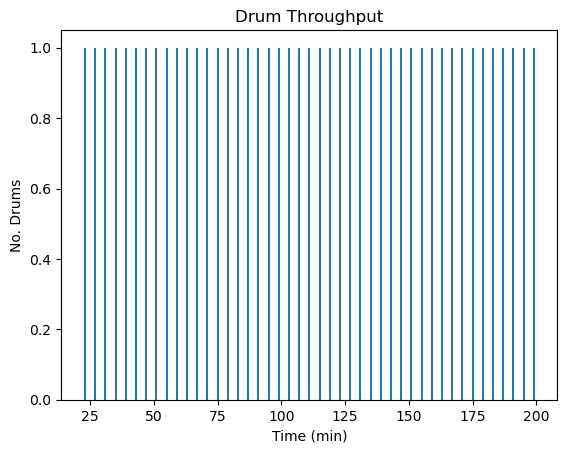

In [4]:
# Extract time and volume data from the list 
time = []
drums = []

for data in drum_throughput:
    time.append(data[0])
    drums.append(data[1])

# Create the plot for drum volume
plt.bar(time, drums)
plt.xlabel('Time (min)')
plt.ylabel('No. Drums')
plt.title('Drum Throughput')

# Display the plot
plt.show()
